https://www.kaggle.com/c/quora-question-pairs


In [2]:
import os, sys, string
import re
import time
import itertools

import tensorflow as tf
import nltk 
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.manifold import TSNE

from collections import Counter


from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


import pprint
pp = pprint.PrettyPrinter(indent=4)
#import tflearn

from pivottablejs import pivot_ui

%load_ext watermark

%watermark -u -n -t -z -v -m -p tensorflow,pandas,scipy,numpy,plotly 

last updated: Sun Jul 23 2017 23:31:21 China Standard Time

CPython 3.5.3
IPython 6.1.0

tensorflow 1.2.1
pandas 0.20.1
scipy 0.19.0
numpy 1.13.1
plotly 2.0.9

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 8.1
machine    : AMD64
processor  : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
# https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# enable output for each command lines. By default, IPython only show ouput for the last command in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read Training Data

In [4]:
# Plotly imports.
# import plotly.offline as plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


import plotly.figure_factory as ff

import plotly.graph_objs as go
#from plotly.graph_objs import *

init_notebook_mode(connected= True)

In [5]:
df = pd.read_csv("./data/train.csv", encoding='utf-8').fillna("")

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%


0    1
1    3
2    5
3    7
4    9
dtype: int64

Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


(array([  5.21491000e+05,   9.55300000e+03,   2.93000000e+03,
          1.44500000e+03,   7.90000000e+02,   5.32000000e+02,
          3.70000000e+02,   2.68000000e+02,   2.03000000e+02,
          1.01000000e+02,   7.70000000e+01,   3.50000000e+01,
          3.50000000e+01,   3.30000000e+01,   2.10000000e+01,
          1.70000000e+01,   1.50000000e+01,   6.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

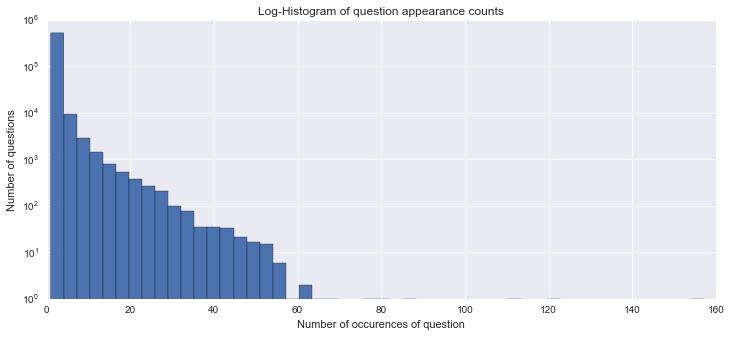

In [6]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

    
df_qids = pd.concat((df['qid1'],df['qid2']), axis =0) #pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
df_qids.head()
#df_qids = pd.Categorical(df_qids)


print('Total number of questions in the training data: {}'.format(len(
    np.unique(df_qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(df_qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(df_qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [ ]:
# df_qids.columns = ["qid"]
# df_qids.dtypes
# df_qids.columns
#df_qids
#trace = go.Histogram(df_qids)
#iplot([trace])

In [11]:

qids_count = Counter(df_qids)
#qids_count.most_common(1000)
#qids_count.keys()
#qids_count.values()

# sns.barplot(x="day", y="total_bill", data=qids_count)

# #sns.barplot(x=qids_count.keys(), y=qids_count.values())

qids, counts = zip(*qids_count.most_common(5))
qids, counts
qids = list(map(str, qids))

# trace = dict(x=qids, y=counts)
# data = [trace]
# py.plot(data, filename='ia_county_populations')

data = [go.Bar(x=qids, y=list(counts), name='Counts')]
data
iplot(data)

((2559, 30782, 4044, 2561, 14376), (157, 120, 111, 88, 79))

[{'name': 'Counts',
  'type': 'bar',
  'x': ['2559', '30782', '4044', '2561', '14376'],
  'y': [157, 120, 111, 88, 79]}]

In [ ]:
df.head(10)
df.tail(10)

In [ ]:
df.info()
df.shape
df.describe()

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

## Feature Extraction

### 1. TF-IDF

In [ ]:
# X_train_q1, X_train_q2 = X_train[['id','qid1', 'question1']], X_train[['id','qid2', 'question2']]
# X_train_q1.columns = ['id','qid1', 'question']
# X_train_q2.columns = ['id','qid2', 'question']

# # merge two two dfs, there are two nans for question
# X_train_q = pd.concat((X_train_q1, X_train_q2), axis=0).fillna("")
# nrows_for_q1 = X_train_q2.shape[0]/2
# X_train_q2.shape
# nrows_for_q1

In [ ]:
# mq1 = TfidfVectorizer(max_features = 256).fit_transform(X_train_q['question'].values)
# mq1

# diff_encodings = np.abs(mq1[::2] - mq1[1::2])
# diff_encodings

####  TSNE 

## Word Tokenizer and Word Share

In [1]:



def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))

# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=False, rm_punc = False, rm_stop_words = True):
    word = word.lower()
    if rm_punc == True and word in set(string.punctuation):
        return None
    
    if rm_stop_words == True and word in stopwords.words('english'):
        return None
    
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
        
    if (wordset == None) or (word in wordset): return word
    else: return "<unk>" # unknown token

stemmer = SnowballStemmer("english")    
def count_words(row, col, start_token = False, stemming = False):
    s = row[col]
    if start_token == False:
        tokens = [word_tokenize(t) for t in sent_tokenize(s)]
    else:
        tokens = (["<s>"] + word_tokenize(t) + ["</s>"] for t in sent_tokenize(s)) # generator expression
    #return [canonicalize_word(w) for w in flatten(tokens)]    
    words = []

    for w in flatten(tokens):
        w_ = canonicalize_word(w)
        if w_ != None:                    
            if stemming:
                w_ = stemmer.stem(w_)
            words.append(w_)
    return words
           
def word_share(row, col1, col2):
    word_set1 = set(row[col1])
    word_set2 = set(row[col2])
    return 1.0 * len(word_set1 & word_set2)/(len(word_set1) + len(word_set2))

    return 1.0 * len(word_set1 & word_set2)/(len(word_set1) + len(word_set2))


NameError: name 'SnowballStemmer' is not defined

In [ ]:
df['words1'] = df.apply(count_words, axis=1, col = 'question1')
df['words2'] = df.apply(count_words, axis=1, col = 'question2')

df['q1_n_words'] = df['words1'].apply(lambda words: len(words))
df['q2_n_words'] = df['words2'].apply(lambda words: len(words))

df['words_share'] = df.apply(word_share, axis=1, col1 = 'words1', col2 = 'words2')

df.head()

In [ ]:
X = df
Y = df[['id','is_duplicate']]

# leave out 20% for test set set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=42)

X_train
Y_train

X_test
Y_test

In [ ]:
X_train_mini = X_train[:5000].copy()


# X_train_mini['words1'] = X_train_mini.apply(count_words, axis=1, col = 'question1')
# X_train_mini['words2'] = X_train_mini.apply(count_words, axis=1, col = 'question2')

# X_train_mini['q1_n_words'] = X_train_mini['words1'].apply(lambda words: len(words))
# X_train_mini['q2_n_words'] = X_train_mini['words2'].apply(lambda words: len(words))

# X_train_mini['words_share'] = X_train_mini.apply(word_share, axis=1, col1 = 'words1', col2 = 'words2')

# X_train_mini.head()

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_share', data = X_train)
plt.subplot(1,2,2)
sns.distplot(X_train_mini[X_train['is_duplicate'] == 1.0]['words_share'], color = 'green')
sns.distplot(X_train_mini[X_train['is_duplicate'] == 0.0]['words_share'], color = 'red')

In [ ]:
trace = go.Scatter(
    y = X_train_mini['q1_n_words'].values,
    x = X_train_mini['q2_n_words'].values,
    mode='markers',
    marker=dict(
        size= X_train_mini['words_share'].values * 60,
        color = X_train_mini['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(X_train_mini['words_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of word count of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question words count',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')



### 2. Embedding 

In [ ]:
from sklearn.preprocessing import MinMaxScaler


X_ = MinMaxScaler().fit_transform(X_train_mini[['q1_n_words', 'q2_n_words', 'words_share']])
Y_ = X_train_mini['is_duplicate'].values

In [ ]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(X_)

In [ ]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = Y_,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.50
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## Model 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

# split the Train test into Train and Dev 
# X_train_, X_dev_, Y_train_, Y_dev_ = model_selection.train_test_split(
#                 X_train[['q1_n_words', 'q2_n_words', 'words_share']], 
#                 Y_train['is_duplicate'], 
#                 test_size=0.25, 
#                 random_state=777)


X_ = MinMaxScaler().fit_transform(X_train[['q1_n_words', 'q2_n_words', 'words_share']])
Y_ = Y_train['is_duplicate']

#X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])


X_train_, X_dev_, Y_train_, Y_dev_ = train_test_split(X_, Y_, test_size=0.25, random_state=777)

X_train_.shape, X_dev_.shape, Y_train_.shape, Y_dev_.shape

X_train_
Y_train_
X_dev_
Y_dev_



In [ ]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train_, Y_train_)

In [ ]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

In [ ]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

#### ROC


In [1]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train_, Y_train_)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(Y_dev_, clf.predict_proba(X_dev_)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))


NameError: name 'plt' is not defined

### Precision-Recall Curve


In [ ]:
pr, re, _ = precision_recall_curve(Y_dev_, cv.best_estimator_.predict_proba(X_dev_)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')